In [1]:
import pandas as pd
import numpy as np

import ast

from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics.pairwise import cosine_similarity

from scipy.stats import spearmanr, pearsonr

import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from scipy.sparse import lil_matrix

import re

In [2]:
# read data
df = pd.read_csv('../data/twitter/train_processed.csv')
df['processed_text'] = df['processed_text'].apply(lambda x: ast.literal_eval(x))
tokenized_sentences = list(df['processed_text'])

In [3]:
def create_co_matrix(vocab: dict, window_size: int, tokenized_sentences: list):
    vocab_size = len(vocab)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.float32)

    for sentence in tokenized_sentences:
        sentence_length = len(sentence)
        for idx, word in enumerate(sentence):
            word_idx = vocab[word]
            
            # Define the context window
            start = max(0, idx - window_size)
            end = min(sentence_length, idx + window_size + 1)
            
            # Update co-occurrence counts for words in the window
            for context_idx in range(start, end):
                if idx != context_idx:  # Skip the word itself
                    context_word_idx = vocab[sentence[context_idx]]
                    co_matrix[word_idx, context_word_idx] += 1

    return co_matrix

def create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, k):
    sppmi_matrix = np.zeros_like(co_matrix)
    
    # Find indices where co_matrix > 0
    rows, cols = np.nonzero(co_matrix)

    for i, j in zip(rows, cols):
        pmi = np.log((co_matrix[i, j] * co_occurrence_sum) / (word_occurrences[i] * word_occurrences[j]))
        sppmi = pmi - np.log(k)
        sppmi_matrix[i, j] = max(sppmi, 0)  # SPPMI

    return sppmi_matrix

In [4]:
vocab = {
    word: idx for idx, word in enumerate(set(word for sentence in tokenized_sentences for word in sentence))
}

In [5]:
dimensions = [128, 256, 300] # dimension vectors of svd
window_sizes = [2, 5, 10]
ks = [5, 10, 15] # for SPPMI

svd_models = {}
sppmi_embeddings = {}

for d in dimensions:
    for w in window_sizes:
        for k in ks:
            co_matrix = create_co_matrix(vocab, w, tokenized_sentences)
            co_occurrence_sum = np.sum(co_matrix)
            word_occurrences = np.sum(co_matrix, axis=1)
            
            # create sppmi matrix
            sppmi_matrix = create_sppmi_matrix(co_matrix, co_occurrence_sum, word_occurrences, k)

            # fit svd
            print(f'Fitting SVD model with dimensions = {d}, window size = {w}, k = {k}')
            
            svd = TruncatedSVD(n_components=d)
            U_k = svd.fit_transform(sppmi_matrix)
            Sigma_k = np.diag(svd.singular_values_)
            Sigma_k_sqrt = np.sqrt(Sigma_k)
            sppmi_embedding = U_k @ Sigma_k_sqrt

            # save model in dictionary
            svd_models[(d, w, k)] = svd

            # save embeddings in dictionary
            sppmi_embeddings[(d, w, k)] = sppmi_embedding

Fitting SVD model with dimensions = 128, window size = 2, k = 5
Fitting SVD model with dimensions = 128, window size = 2, k = 10
Fitting SVD model with dimensions = 128, window size = 2, k = 15
Fitting SVD model with dimensions = 128, window size = 5, k = 5
Fitting SVD model with dimensions = 128, window size = 5, k = 10
Fitting SVD model with dimensions = 128, window size = 5, k = 15
Fitting SVD model with dimensions = 128, window size = 10, k = 5
Fitting SVD model with dimensions = 128, window size = 10, k = 10
Fitting SVD model with dimensions = 128, window size = 10, k = 15
Fitting SVD model with dimensions = 256, window size = 2, k = 5
Fitting SVD model with dimensions = 256, window size = 2, k = 10
Fitting SVD model with dimensions = 256, window size = 2, k = 15
Fitting SVD model with dimensions = 256, window size = 5, k = 5
Fitting SVD model with dimensions = 256, window size = 5, k = 10
Fitting SVD model with dimensions = 256, window size = 5, k = 15
Fitting SVD model with dime

## Analysis

### Evaluation of quality of embeddings of each model with Wordsim353

In [6]:
word_to_index = vocab
index_to_word = {idx: word for word, idx in vocab.items()}

def evaluate_correlation_wordsim(df, sppmi_embedding):
    df1 = df.copy()

    preds = []

    for _, row in df1.iterrows():
        w1, w2 = row['Word 1'], row['Word 2']
        if w1 in word_to_index and w2 in word_to_index:
            vec1 = sppmi_embedding[word_to_index[w1]].reshape(1, -1)
            vec2 = sppmi_embedding[word_to_index[w2]].reshape(1, -1)
            sim = cosine_similarity(vec1, vec2)[0][0]
            preds.append(sim)
        else:
            preds.append(np.nan) # result not available

    df1['preds'] = preds
    df1 = df1.dropna()

    # compute correlations
    print("Spearman correlation:", spearmanr(df1['preds'], df1['Human (Mean)'])[0])
    print("Pearson correlation:", pearsonr(df1['preds'], df1['Human (Mean)'])[0])

In [7]:
wordsim = pd.read_csv('../data/evaluation/wordsim353crowd.csv')

In [8]:
for key, model in svd_models.items():
    vector_size, window, k = key

    print(f'Model parameters are: vector size = {vector_size}, window = {window}, k = {k}')
    evaluate_correlation_wordsim(wordsim, sppmi_embeddings[key])
    print("*" * 50)

Model parameters are: vector size = 128, window = 2, k = 5
Spearman correlation: 0.12707817375126146
Pearson correlation: 0.24043892252423726
**************************************************
Model parameters are: vector size = 128, window = 2, k = 10
Spearman correlation: 0.14603732233096348
Pearson correlation: 0.25432280713839417
**************************************************
Model parameters are: vector size = 128, window = 2, k = 15
Spearman correlation: 0.08800668812905735
Pearson correlation: 0.20357503776339664
**************************************************
Model parameters are: vector size = 128, window = 5, k = 5
Spearman correlation: 0.04847575274990655
Pearson correlation: 0.15758953741595572
**************************************************
Model parameters are: vector size = 128, window = 5, k = 10
Spearman correlation: 0.002792450426740737
Pearson correlation: 0.12489530498455009
**************************************************
Model parameters are: vector si

Best model parameters based on Spearman correlation for SPPMI-SVD are: vector size = 300, window = 2, k = 15.

Use these parameters for subsequent analysis on the svd embeddings.

### Nearest Neighbours for selected words

In [9]:
word_to_index = vocab
index_to_word = {idx: word for word, idx in vocab.items()}

def get_similar_words(word, embeddings, top_k=10):
    idx = word_to_index[word]
    vec = embeddings[idx].reshape(1, -1)
    sims = cosine_similarity(vec, embeddings)[0]
    # Get top_n indices (excluding the word itself)
    top_indices = np.argsort(-sims)[1:top_k + 1]
    return [(index_to_word[i], sims[i]) for i in top_indices]

In [10]:
selected_words = [
    'sad',
    'chocolate',
    'chemistry',
    'month',
    'news'
]

best_sppmi_embedding = sppmi_embeddings[(300, 2, 15)]

for word in selected_words:
    print(f"Similar words to '{word}':")
    print(get_similar_words(word, best_sppmi_embedding))
    print("*" * 30)

Similar words to 'sad':
[('pandemic', 0.74267113), ('agreekids', 0.7262522), ('knowits', 0.6380523), ('hydrangeahow', 0.6174997), ('touching', 0.56041217), ('calderon', 0.5277214), ('kinna', 0.49945587), ('cemburuuu', 0.4884805), ('incredible', 0.48277053), ('62', 0.46304002)]
******************************
Similar words to 'chocolate':
[('superaddict', 0.7962632), ('dagoba', 0.78641397), ('croissant', 0.6667089), ('milk', 0.6384534), ('fridayand', 0.54884434), ('consecutive', 0.5404793), ('ohhhh', 0.5237143), ('peach', 0.5170546), ('toscanis', 0.49184585), ('ice', 0.4878045)]
******************************
Similar words to 'chemistry':
[('chemistrybaaahh', 0.7836255), ('homework', 0.67792594), ('mention', 0.67455614), ('study', 0.6437306), ('finnaaaallly', 0.62126446), ('aaa', 0.5629728), ('gayy', 0.5599181), ('winterrrrr', 0.558226), ('gucci', 0.5573387), ('norwegian', 0.5505754)]
******************************
Similar words to 'month':
[('pregnant', 0.6898627), ('reservation', 0.687

Similar words are sometimes unreasonable, like for sad, month and news.

Other similar words seem to be more similar, like for chocolate and chemistry.

### Visualization of embedding space

In [11]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(best_sppmi_embedding)

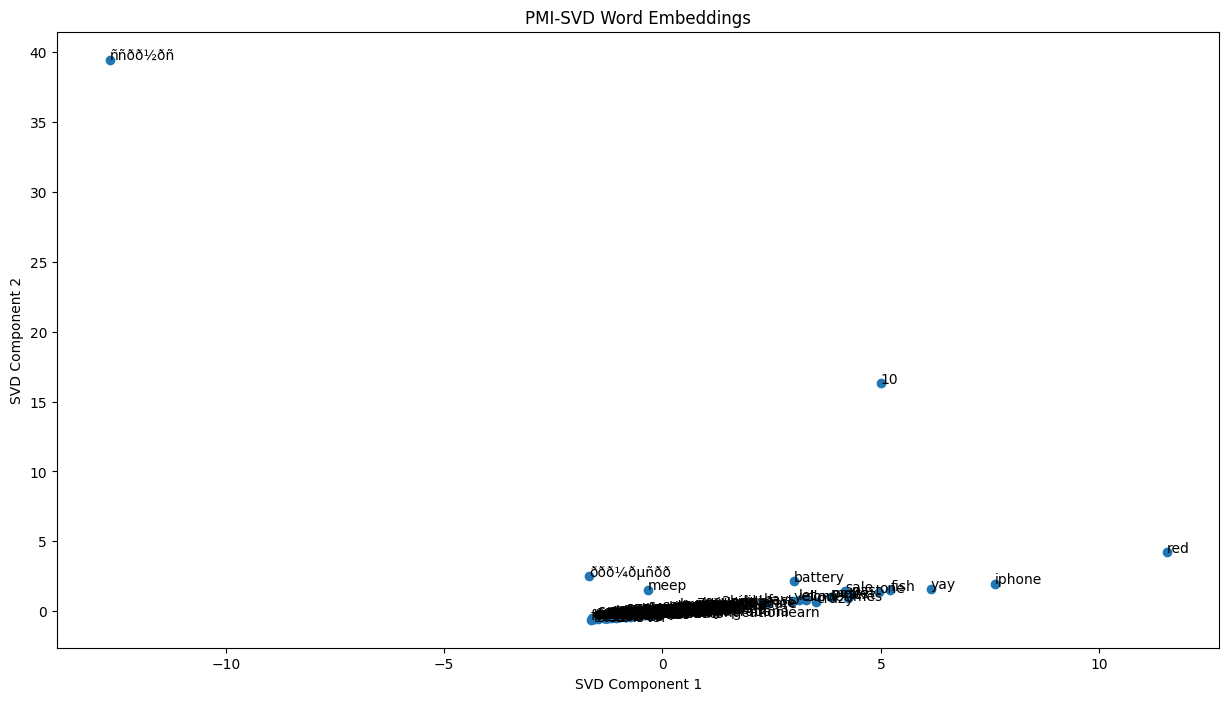

In [14]:
words = list(vocab.keys())[:200]

plt.figure(figsize=(15, 8))
plt.scatter(reduced_embeddings[:200, 0], reduced_embeddings[:200, 1])
for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))
plt.title("PMI-SVD Word Embeddings")
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.show()

Most words cluster together near the origin, except a few words that are spread further apart.